In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
tqdm.pandas(desc="progress-bar")
import gensim
import gensim.downloader as api
from gensim import models
from gensim.models import Doc2Vec
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import plot_confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from gensim.models.doc2vec import TaggedDocument
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
df = pd.read_excel('Code Mixed Hindi-English tweets.xlsx')
df.drop(['id'],axis=1, inplace=True)
df

,tweets,labels
0,aaj ka khel khatam hone k baad england cricket...,0
1,purana manjan bech rha hai,5
2,tumhare disappointed se kuch ni hoga,0
3,inse bas tiktok banva lo batting ni hoti isse ...,3
4,bhai cricket par tweets mat kara karo please j...,3
...,...,...
9160,gujarati fraud kyu hotey hai? pnbscam,3
9161,saala idhar 7 lakh k car loan k liye bank choo...,3
9162,mitron nirav modi ji ka relation india k kaun ...,3
9163,or yahn ek month k education loan ki emi pay n...,2


## Labels are as follows:
0 - No emotions,
1 - Happy,
2 - Sad,
3 - Angry,
4 - Fear,
5 - Disgust,
6 - Surprise

In [3]:
print("Dataset shape: ", df.shape)
df['labels'].value_counts()

Dataset shape:  (9165, 2)


0    1892
3    1763
2    1529
1    1226
5    1147
6    1049
4     559
Name: labels, dtype: int64

# Cleaning data:

### Cleaning and removing Punctuations:

In [4]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [5]:
punctuations_list = string.punctuation
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

df['tweets'] = df['tweets'].apply(lambda x: cleaning_punctuations(x))

### Cleaning and removing Stopwords:

In [6]:
# Using Hinglish stopwords which contains 1036 words from both English and Hindi languages
# Source: https://github.com/TrigonaMinima/HinglishNLP/blob/master/data/assets/stop_hinglish

stopwordlist = ['a', 'aadi', 'aaj', 'aap', 'aapne', 'aata', 'aati', 'aaya', 'aaye', 'ab', 'abbe', 'abbey', 'abe', 'abhi', 'able', 'about', 'above', 'accha', 'according', 'accordingly', 'acha', 'achcha', 'across', 'actually', 'after', 'afterwards', 'again', 'against', 'agar', 'ain', 'aint', "ain't", 'aisa', 'aise', 'aisi', 'alag', 'all', 'allow', 'allows', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'an', 'and', 'andar', 'another', 'any', 'anybody', 'anyhow', 'anyone', 'anything', 'anyway', 'anyways', 'anywhere', 'ap', 'apan', 'apart', 'apna', 'apnaa', 'apne', 'apni', 'appear', 'are', 'aren', 'arent', "aren't", 'around', 'arre', 'as', 'aside', 'ask', 'asking', 'at', 'aur', 'avum', 'aya', 'aye', 'baad', 'baar', 'bad', 'bahut', 'bana', 'banae', 'banai', 'banao', 'banaya', 'banaye', 'banayi', 'banda', 'bande', 'bandi', 'bane', 'bani', 'bas', 'bata', 'batao', 'bc', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being', 'below', 'beside', 'besides', 'best', 'better', 'between', 'beyond', 'bhai', 'bheetar', 'bhi', 'bhitar', 'bht', 'bilkul', 'bohot', 'bol', 'bola', 'bole', 'boli', 'bolo', 'bolta', 'bolte', 'bolti', 'both', 'brief', 'bro', 'btw', 'but', 'by', 'came', 'can', 'cannot', 'cant', "can't", 'cause', 'causes', 'certain', 'certainly', 'chahiye', 'chaiye', 'chal', 'chalega', 'chhaiye', 'clearly', "c'mon", 'com', 'come', 'comes', 'could', 'couldn', 'couldnt', "couldn't", 'd', 'de', 'dede', 'dega', 'degi', 'dekh', 'dekha', 'dekhe', 'dekhi', 'dekho', 'denge', 'dhang', 'di', 'did', 'didn', 'didnt', "didn't", 'dijiye', 'diya', 'diyaa', 'diye', 'diyo', 'do', 'does', 'doesn', 'doesnt', "doesn't", 'doing', 'done', 'dono', 'dont', "don't", 'doosra', 'doosre', 'down', 'downwards', 'dude', 'dunga', 'dungi', 'during', 'dusra', 'dusre', 'dusri', 'dvaara', 'dvara', 'dwaara', 'dwara', 'each', 'edu', 'eg', 'eight', 'either', 'ek', 'else', 'elsewhere', 'enough', 'etc', 'even', 'ever', 'every', 'everybody', 'everyone', 'everything', 'everywhere', 'ex', 'exactly', 'example', 'except', 'far', 'few', 'fifth', 'fir', 'first', 'five', 'followed', 'following', 'follows', 'for', 'forth', 'four', 'from', 'further', 'furthermore', 'gaya', 'gaye', 'gayi', 'get', 'gets', 'getting', 'ghar', 'given', 'gives', 'go', 'goes', 'going', 'gone', 'good', 'got', 'gotten', 'greetings', 'haan', 'had', 'hadd', 'hadn', 'hadnt', "hadn't", 'hai', 'hain', 'hamara', 'hamare', 'hamari', 'hamne', 'han', 'happens', 'har', 'hardly', 'has', 'hasn', 'hasnt', "hasn't", 'have', 'haven', 'havent', "haven't", 'having', 'he', 'hello', 'help', 'hence', 'her', 'here', 'hereafter', 'hereby', 'herein', "here's", 'hereupon', 'hers', 'herself', "he's", 'hi', 'him', 'himself', 'his', 'hither', 'hm', 'hmm', 'ho', 'hoga', 'hoge', 'hogi', 'hona', 'honaa', 'hone', 'honge', 'hongi', 'honi', 'hopefully', 'hota', 'hotaa', 'hote', 'hoti', 'how', 'howbeit', 'however', 'hoyenge', 'hoyengi', 'hu', 'hua', 'hue', 'huh', 'hui', 'hum', 'humein', 'humne', 'hun', 'huye', 'huyi', 'i', "i'd", 'idk', 'ie', 'if', "i'll", "i'm", 'imo', 'in', 'inasmuch', 'inc', 'inhe', 'inhi', 'inho', 'inka', 'inkaa', 'inke', 'inki', 'inn', 'inner', 'inse', 'insofar', 'into', 'inward', 'is', 'ise', 'isi', 'iska', 'iskaa', 'iske', 'iski', 'isme', 'isn', 'isne', 'isnt', "isn't", 'iss', 'isse', 'issi', 'isski', 'it', "it'd", "it'll", 'itna', 'itne', 'itni', 'itno', 'its', "it's", 'itself', 'ityaadi', 'ityadi', "i've", 'ja', 'jaa', 'jab', 'jabh', 'jaha', 'jahaan', 'jahan', 'jaisa', 'jaise', 'jaisi', 'jata', 'jayega', 'jidhar', 'jin', 'jinhe', 'jinhi', 'jinho', 'jinhone', 'jinka', 'jinke', 'jinki', 'jinn', 'jis', 'jise', 'jiska', 'jiske', 'jiski', 'jisme', 'jiss', 'jisse', 'jitna', 'jitne', 'jitni', 'jo', 'just', 'jyaada', 'jyada', 'k', 'ka', 'kaafi', 'kab', 'kabhi', 'kafi', 'kaha', 'kahaa', 'kahaan', 'kahan', 'kahi', 'kahin', 'kahte', 'kaisa', 'kaise', 'kaisi', 'kal', 'kam', 'kar', 'kara', 'kare', 'karega', 'karegi', 'karen', 'karenge', 'kari', 'karke', 'karna', 'karne', 'karni', 'karo', 'karta', 'karte', 'karti', 'karu', 'karun', 'karunga', 'karungi', 'kaun', 'kaunsa', 'kayi', 'kch', 'ke', 'keep', 'keeps', 'keh', 'kehte', 'kept', 'khud', 'ki', 'kin', 'kine', 'kinhe', 'kinho', 'kinka', 'kinke', 'kinki', 'kinko', 'kinn', 'kino', 'kis', 'kise', 'kisi', 'kiska', 'kiske', 'kiski', 'kisko', 'kisliye', 'kisne', 'kitna', 'kitne', 'kitni', 'kitno', 'kiya', 'kiye', 'know', 'known', 'knows', 'ko', 'koi', 'kon', 'konsa', 'koyi', 'krna', 'krne', 'kuch', 'kuchch', 'kuchh', 'kul', 'kull', 'kya', 'kyaa', 'kyu', 'kyuki', 'kyun', 'kyunki', 'lagta', 'lagte', 'lagti', 'last', 'lately', 'later', 'le', 'least', 'lekar', 'lekin', 'less', 'lest', 'let', "let's", 'li', 'like', 'liked', 'likely', 'little', 'liya', 'liye', 'll', 'lo', 'log', 'logon', 'lol', 'look', 'looking', 'looks', 'ltd', 'lunga', 'm', 'maan', 'maana', 'maane', 'maani', 'maano', 'magar', 'mai', 'main', 'maine', 'mainly', 'mana', 'mane', 'mani', 'mano', 'many', 'mat', 'may', 'maybe', 'me', 'mean', 'meanwhile', 'mein', 'mera', 'mere', 'merely', 'meri', 'might', 'mightn', 'mightnt', "mightn't", 'mil', 'mjhe', 'more', 'moreover', 'most', 'mostly', 'much', 'mujhe', 'must', 'mustn', 'mustnt', "mustn't", 'my', 'myself', 'na', 'naa', 'naah', 'nahi', 'nahin', 'nai', 'name', 'namely', 'nd', 'ne', 'near', 'nearly', 'necessary', 'neeche', 'need', 'needn', 'neednt', "needn't", 'needs', 'neither', 'never', 'nevertheless', 'new', 'next', 'nhi', 'nine', 'no', 'nobody', 'non', 'none', 'noone', 'nope', 'nor', 'normally', 'not', 'nothing', 'novel', 'now', 'nowhere', 'o', 'obviously', 'of', 'off', 'often', 'oh', 'ok', 'okay', 'old', 'on', 'once', 'one', 'ones', 'only', 'onto', 'or', 'other', 'others', 'otherwise', 'ought', 'our', 'ours', 'ourselves', 'out', 'outside', 'over', 'overall', 'own', 'par', 'pata', 'pe', 'pehla', 'pehle', 'pehli', 'people', 'per', 'perhaps', 'phla', 'phle', 'phli', 'placed', 'please', 'plus', 'poora', 'poori', 'provides', 'pura', 'puri', 'q', 'que', 'quite', 'raha', 'rahaa', 'rahe', 'rahi', 'rakh', 'rakha', 'rakhe', 'rakhen', 'rakhi', 'rakho', 'rather', 're', 'really', 'reasonably', 'regarding', 'regardless', 'regards', 'rehte', 'rha', 'rhaa', 'rhe', 'rhi', 'ri', 'right', 's', 'sa', 'saara', 'saare', 'saath', 'sab', 'sabhi', 'sabse', 'sahi', 'said', 'sakta', 'saktaa', 'sakte', 'sakti', 'same', 'sang', 'sara', 'sath', 'saw', 'say', 'saying', 'says', 'se', 'second', 'secondly', 'see', 'seeing', 'seem', 'seemed', 'seeming', 'seems', 'seen', 'self', 'selves', 'sensible', 'sent', 'serious', 'seriously', 'seven', 'several', 'shall', 'shan', 'shant', "shan't", 'she', "she's", 'should', 'shouldn', 'shouldnt', "shouldn't", "should've", 'si', 'since', 'six', 'so', 'soch', 'some', 'somebody', 'somehow', 'someone', 'something', 'sometime', 'sometimes', 'somewhat', 'somewhere', 'soon', 'still', 'sub', 'such', 'sup', 'sure', 't', 'tab', 'tabh', 'tak', 'take', 'taken', 'tarah', 'teen', 'teeno', 'teesra', 'teesre', 'teesri', 'tell', 'tends', 'tera', 'tere', 'teri', 'th', 'tha', 'than', 'thank', 'thanks', 'thanx', 'that', "that'll", 'thats', "that's", 'the', 'theek', 'their', 'theirs', 'them', 'themselves', 'then', 'thence', 'there', 'thereafter', 'thereby', 'therefore', 'therein', 'theres', "there's", 'thereupon', 'these', 'they', "they'd", "they'll", "they're", "they've", 'thi', 'thik', 'thing', 'think', 'thinking', 'third', 'this', 'tho', 'thoda', 'thodi', 'thorough', 'thoroughly', 'those', 'though', 'thought', 'three', 'through', 'throughout', 'thru', 'thus', 'tjhe', 'to', 'together', 'toh', 'too', 'took', 'toward', 'towards', 'tried', 'tries', 'true', 'truly', 'try', 'trying', 'tu', 'tujhe', 'tum', 'tumhara', 'tumhare', 'tumhari', 'tune', 'twice', 'two', 'um', 'umm', 'un', 'under', 'unhe', 'unhi', 'unho', 'unhone', 'unka', 'unkaa', 'unke', 'unki', 'unko', 'unless', 'unlikely', 'unn', 'unse', 'until', 'unto', 'up', 'upar', 'upon', 'us', 'use', 'used', 'useful', 'uses', 'usi', 'using', 'uska', 'uske', 'usne', 'uss', 'usse', 'ussi', 'usually', 'vaala', 'vaale', 'vaali', 'vahaan', 'vahan', 'vahi', 'vahin', 'vaisa', 'vaise', 'vaisi', 'vala', 'vale', 'vali', 'various', 've', 'very', 'via', 'viz', 'vo', 'waala', 'waale', 'waali', 'wagaira', 'wagairah', 'wagerah', 'waha', 'wahaan', 'wahan', 'wahi', 'wahin', 'waisa', 'waise', 'waisi', 'wala', 'wale', 'wali', 'want', 'wants', 'was', 'wasn', 'wasnt', "wasn't", 'way', 'we', "we'd", 'well', "we'll", 'went', 'were', "we're", 'weren', 'werent', "weren't", "we've", 'what', 'whatever', "what's", 'when', 'whence', 'whenever', 'where', 'whereafter', 'whereas', 'whereby', 'wherein', "where's", 'whereupon', 'wherever', 'whether', 'which', 'while', 'who', 'whoever', 'whole', 'whom', "who's", 'whose', 'why', 'will', 'willing', 'with', 'within', 'without', 'wo', 'woh', 'wohi', 'won', 'wont', "won't", 'would', 'wouldn', 'wouldnt', "wouldn't", 'y', 'ya', 'yadi', 'yah', 'yaha', 'yahaan', 'yahan', 'yahi', 'yahin', 'ye', 'yeah', 'yeh', 'yehi', 'yes', 'yet', 'you', "you'd", "you'll", 'your', "you're", 'yours', 'yourself', 'yourselves', "you've", 'yup']

In [7]:
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

df['tweets'] = df['tweets'].apply(lambda text: cleaning_stopwords(text))

### Cleaning and removing Numeric numbers:

In [8]:
def cleaning_numbers(text):
    return re.sub('[0-9]+', '', text)

df['tweets'] = df['tweets'].apply(lambda text: cleaning_numbers(text))

# Splitting data into Train and Test

In [9]:
train, test = train_test_split(df, test_size=0.2, random_state=3)

In [10]:
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

In [11]:
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['tweets']), tags=[r.labels]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['tweets']), tags=[r.labels]), axis=1)

In [12]:
train_tagged.values[0]

TaggedDocument(words=['modi', 'ensure', 'kr', 'demonetization', 'gst', 'unthinkable', 'rates', 'garib', 'marr', 'jai', 'ni', 'garib', 'ni', 'rahegi', 'garibi'], tags=[2])

# Doc2vec:
### 1. Distributed Bag of Words (DBOW)
Note: If dm=0, distributed bag of words (PV-DBOW) is used; if dm=1,‘distributed memory’ (PV-DM) is used.

In [13]:
import multiprocessing
cores = multiprocessing.cpu_count()

### Building model:

In [14]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

  0%|          | 0/7332 [00:00<?, ?it/s]

In [15]:
for epoch in range(30):
    model_dbow.train(shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

  0%|          | 0/7332 [00:00<?, ?it/s]

  0%|          | 0/7332 [00:00<?, ?it/s]

  0%|          | 0/7332 [00:00<?, ?it/s]

  0%|          | 0/7332 [00:00<?, ?it/s]

  0%|          | 0/7332 [00:00<?, ?it/s]

  0%|          | 0/7332 [00:00<?, ?it/s]

  0%|          | 0/7332 [00:00<?, ?it/s]

  0%|          | 0/7332 [00:00<?, ?it/s]

  0%|          | 0/7332 [00:00<?, ?it/s]

  0%|          | 0/7332 [00:00<?, ?it/s]

  0%|          | 0/7332 [00:00<?, ?it/s]

  0%|          | 0/7332 [00:00<?, ?it/s]

  0%|          | 0/7332 [00:00<?, ?it/s]

  0%|          | 0/7332 [00:00<?, ?it/s]

  0%|          | 0/7332 [00:00<?, ?it/s]

  0%|          | 0/7332 [00:00<?, ?it/s]

  0%|          | 0/7332 [00:00<?, ?it/s]

  0%|          | 0/7332 [00:00<?, ?it/s]

  0%|          | 0/7332 [00:00<?, ?it/s]

  0%|          | 0/7332 [00:00<?, ?it/s]

  0%|          | 0/7332 [00:00<?, ?it/s]

  0%|          | 0/7332 [00:00<?, ?it/s]

  0%|          | 0/7332 [00:00<?, ?it/s]

  0%|          | 0/7332 [00:00<?, ?it/s]

  0%|          | 0/7332 [00:00<?, ?it/s]

  0%|          | 0/7332 [00:00<?, ?it/s]

  0%|          | 0/7332 [00:00<?, ?it/s]

  0%|          | 0/7332 [00:00<?, ?it/s]

  0%|          | 0/7332 [00:00<?, ?it/s]

  0%|          | 0/7332 [00:00<?, ?it/s]

# Building the Final Vector Feature for the Classifier

In [16]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words)) for doc in sents])
    return targets, regressors

# Splitting data into Train and Test

In [17]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

# Building Models:

## 1. SVC:

In [18]:
kernels = ['rbf','linear','poly','sigmoid']

svc = SVC()
hyperParam = {'C': [0.1, 1, 10, 100, 1000],'gamma': [1, 0.1, 0.01, 0.001],'kernel': ['rbf','linear','poly','sigmoid']}

gsv = GridSearchCV(svc,hyperParam,cv=5,verbose=1)
best_model = gsv.fit(X_train, y_train)                        # Fitting model with X_train and y_train
svc_pred = best_model.predict(X_test)                         # Predicting the results

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy :",best_model.score(X_test, y_test))

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Best HyperParameter:  {'C': 100, 'gamma': 1, 'kernel': 'linear'}
Best Accuracy : 0.4075286415711948


              precision    recall  f1-score   support

           0       0.32      0.49      0.39       361
           1       0.29      0.27      0.28       242
           2       0.33      0.31      0.32       310
           3       0.58      0.50      0.54       346
           4       0.72      0.50      0.59       104
           5       0.54      0.44      0.49       239
           6       0.39      0.35      0.37       231

    accuracy                           0.41      1833
   macro avg       0.45      0.41      0.42      1833
weighted avg       0.43      0.41      0.41      1833



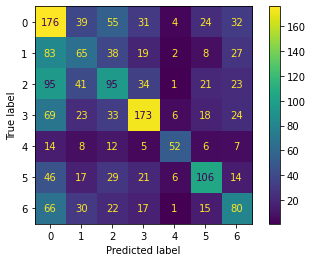

In [19]:
print(metrics.classification_report(y_test, svc_pred))
plot_confusion_matrix(gsv, X_test, y_test)

## 2. Logistic Regression:

In [20]:
c_val = [0.001,0.01,0.1,0.5,1.0]

logreg = LogisticRegression(multi_class='multinomial')
hyperParam = [{'C':c_val}]

gsv = GridSearchCV(logreg,hyperParam,cv=5,verbose=1)
best_model = gsv.fit(X_train, y_train)                         # Fitting model with X_train and y_train
logreg_pred = best_model.predict(X_test)                       # Predicting the results

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy :",best_model.score(X_test, y_test))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best HyperParameter:  {'C': 1.0}
Best Accuracy : 0.40425531914893614


              precision    recall  f1-score   support

           0       0.31      0.49      0.38       361
           1       0.30      0.17      0.22       242
           2       0.36      0.31      0.33       310
           3       0.52      0.55      0.54       346
           4       0.93      0.25      0.39       104
           5       0.57      0.43      0.49       239
           6       0.38      0.46      0.42       231

    accuracy                           0.40      1833
   macro avg       0.48      0.38      0.40      1833
weighted avg       0.43      0.40      0.40      1833



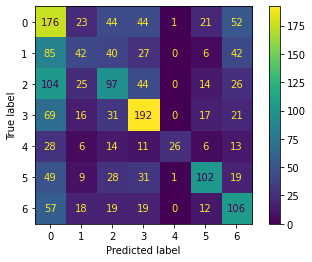

In [21]:
print(metrics.classification_report(y_test, logreg_pred))
plot_confusion_matrix(gsv, X_test, y_test)

## 3. Random Forest:

In [22]:
rf = RandomForestClassifier()
hyperParam = [{'n_estimators' : [1, 5, 10, 20, 50, 100]}]

gsv = GridSearchCV(rf,hyperParam,cv=5,verbose=1)
best_model = gsv.fit(X_train, y_train)                        # Fitting model with X_train and y_train
rf_pred = best_model.predict(X_test)                          # Predicting the results

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy :",best_model.score(X_test, y_test))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best HyperParameter:  {'n_estimators': 100}
Best Accuracy : 0.4004364429896345


              precision    recall  f1-score   support

           0       0.31      0.47      0.38       361
           1       0.27      0.21      0.24       242
           2       0.33      0.32      0.33       310
           3       0.54      0.49      0.51       346
           4       0.71      0.46      0.56       104
           5       0.53      0.46      0.49       239
           6       0.41      0.37      0.39       231

    accuracy                           0.40      1833
   macro avg       0.44      0.40      0.41      1833
weighted avg       0.42      0.40      0.40      1833



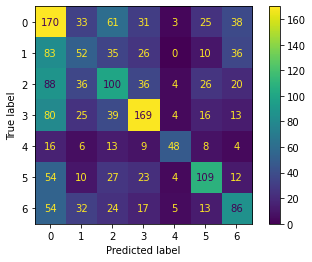

In [23]:
print(metrics.classification_report(y_test, rf_pred))
plot_confusion_matrix(gsv, X_test, y_test)